In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import pygenstability as pgs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse.csgraph import shortest_path
from pygenstability import plotting
import community as community_louvain
from infomap import Infomap

In [10]:
# load the data
Partition_eco = pd.read_csv('data/python/Partition_eco2017.csv')
Partition_road = pd.read_csv('data/python/Partition_road.csv')
# merge two dataframes into one, by the column'display_na' from Partition_eco and column 'city_name' Partition_road
Partition = pd.merge(Partition_eco, Partition_road, left_on='display_na', right_on='city_name')
# drop the column 'city_name'
Partition = Partition.drop(columns=['city_name'])
Partition.sample(3)

,place_id,display_na,name,osm_id,community_GMC_id_8,community_id3
8,378239909,"Huzhou, Zhejiang, China",Huzhou,3149738,1,1
19,391115975,"Wuxi City, Jiangsu, China",Wuxi City,4430942,2,2
13,197160785,"Nantong, Jiangsu, China",Nantong,4430899,0,2


In [11]:
# load the graph from graphml file
G_road = nx.read_graphml('data/python/Spatial_network.graphml')
G_eco = nx.read_graphml('data/python/Industry_network_raw.graphml')
G_ecocut = nx.read_graphml('data/python/Industry_network_cut.graphml')

In [12]:
# convert the 'pos' attribute of the nodes from string to tuple, first need to delete the "(" and ")" in the string, and then split the string by ","
def pos_str_to_tuple(G):
    for node in G.nodes:
        G.nodes[node]['pos'] = tuple(map(float, G.nodes[node]['pos'][1:-1].split(',')))
    return G

G_road = pos_str_to_tuple(G_road)
G_eco = pos_str_to_tuple(G_eco)
G_ecocut = pos_str_to_tuple(G_ecocut)

In [13]:
"""
# change to undirected graph
# the edge weight is the sum of the weight of the two directions in the G_eco graph
for edge in G_eco.edges:
    G_eco.edges[edge]['weight'] = G_eco.edges[edge]['weight'] + G_eco.edges[(edge[1], edge[0])]['weight']
# and then change the graph to undirected
G_eco = G_eco.to_undirected()
#check if the graph is directed 
G_eco.is_directed()
"""

"\n# change to undirected graph\n# the edge weight is the sum of the weight of the two directions in the G_eco graph\nfor edge in G_eco.edges:\n    G_eco.edges[edge]['weight'] = G_eco.edges[edge]['weight'] + G_eco.edges[(edge[1], edge[0])]['weight']\n# and then change the graph to undirected\nG_eco = G_eco.to_undirected()\n#check if the graph is directed \nG_eco.is_directed()\n"

In [14]:
Partition.columns

Index(['place_id', 'display_na', 'name', 'osm_id', 'community_GMC_id_8',
       'community_id3'],
      dtype='object')

In [15]:
eco_com_list = Partition.columns[4:7].tolist()
road_com_list = Partition.columns[8:9].tolist()
road_com_list

[]

In [16]:
# convert the partition results in DataFrame to dictionary
partition_eco = Partition.set_index('display_na')['community_GMC_id_8'].to_dict()
partition_road = Partition.set_index('display_na')['community_id3'].to_dict()

In [17]:
from networkx.algorithms.community import modularity

In [21]:
#convert the partition_road to a list of lists, where each list contains the nodes in the same community
partition_road_list = []
for i in range(0, len(set(partition_road.values()))):
    partition_road_list.append([key for key, value in partition_road.items() if value == i])

partition_eco_list = []
for i in range(0, len(set(partition_eco.values()))):
    partition_eco_list.append([key for key, value in partition_eco.items() if value == i])

modularity(G_road, partition_road_list)

0.2036501937047027

In [40]:
sorted_nodes = sorted(G_road.nodes())
sorted_nodes

['Anqing, Anhui, China',
 'Changzhou, Jiangsu, China',
 'Chizhou, Anhui, China',
 'Chuzhou, Anhui, China',
 'Hangzhou City, Zhejiang, China',
 'Hefei, Anhui, China',
 'Huzhou, Zhejiang, China',
 'Jiaxing, Zhejiang, China',
 'Jinhua, Zhejiang, China',
 "Ma'anshan, Anhui, China",
 'Nanjing, Jiangsu, China',
 'Nantong, Jiangsu, China',
 'Ningbo, Zhejiang, China',
 'Shanghai, China',
 'Shaoxing, Zhejiang, China',
 'Suzhou City, Jiangsu, China',
 'Taizhou, Jiangsu, China',
 'Taizhou, Zhejiang, China',
 'Tongling, Anhui, China',
 'Wuhu, Anhui, China',
 'Wuxi City, Jiangsu, China',
 'Xuancheng, Anhui, China',
 'Yancheng City, Jiangsu, China',
 'Yangzhou City, Jiangsu, China',
 'Zhenjiang, Jiangsu, China',
 'Zhoushan, Zhejiang, China']

In [45]:
from scipy.linalg import inv

def compute_affinity_matrix(G, epsilon=0.01, sorted_nodes=None):
    # 获取邻接矩阵
    A = nx.to_numpy_array(G, nodelist=sorted_nodes, weight='weight')
    # 节点数量
    n = A.shape[0]
    # 度矩阵
    D = np.diag([G.degree(i) for i in G.nodes()])
    # 传播矩阵计算
    S = inv(np.eye(n) + epsilon**2 * D - epsilon * A)
    return S

def delta_con(G1, G2, epsilon=0.01, sorted_nodes=None):
    S_G1 = compute_affinity_matrix(G1, epsilon, sorted_nodes=sorted_nodes)
    S_G2 = compute_affinity_matrix(G2, epsilon, sorted_nodes=sorted_nodes)
    
    # 计算传播距离差异矩阵
    delta = np.sqrt(np.abs(S_G1 - S_G2))
    
    # 计算DeltaCon全局相似度
    delta_con_score = 1 / (1 + np.sum(delta))
    
    return delta_con_score

In [46]:

A = nx.to_numpy_array(G_road, nodelist=sorted_nodes, weight='weight')
B = nx.to_numpy_array(G_eco, nodelist=sorted_nodes, weight='weight')

In [43]:
#check if the G_road and G_eco share the same nodes in the same order
G_eco.nodes() == G_road.nodes()

False

In [44]:
sorted_nodes

['Anqing, Anhui, China',
 'Changzhou, Jiangsu, China',
 'Chizhou, Anhui, China',
 'Chuzhou, Anhui, China',
 'Hangzhou City, Zhejiang, China',
 'Hefei, Anhui, China',
 'Huzhou, Zhejiang, China',
 'Jiaxing, Zhejiang, China',
 'Jinhua, Zhejiang, China',
 "Ma'anshan, Anhui, China",
 'Nanjing, Jiangsu, China',
 'Nantong, Jiangsu, China',
 'Ningbo, Zhejiang, China',
 'Shanghai, China',
 'Shaoxing, Zhejiang, China',
 'Suzhou City, Jiangsu, China',
 'Taizhou, Jiangsu, China',
 'Taizhou, Zhejiang, China',
 'Tongling, Anhui, China',
 'Wuhu, Anhui, China',
 'Wuxi City, Jiangsu, China',
 'Xuancheng, Anhui, China',
 'Yancheng City, Jiangsu, China',
 'Yangzhou City, Jiangsu, China',
 'Zhenjiang, Jiangsu, China',
 'Zhoushan, Zhejiang, China']

In [42]:
# 计算DeltaCon相似度
similarity_score = delta_con(G_road, G_eco, sorted_nodes=sorted_nodes)
print(f"DeltaCon similarity score: {similarity_score}")

DeltaCon similarity score: 0.013478955465142162


True

In [51]:
from math import exp
# Define the function to compute the undirected modularity
def compute_undirected_modularity(G, partition):
    m = G.size(weight='weight')
    Q = 0.0
    for u in G.nodes():
        for v in G.nodes():
            if partition[u] == partition[v]:
                A_uv = G[u][v]['weight'] if G.has_edge(u, v) else 0.0
                k_u = G.degree(u, weight='weight')
                k_v = G.degree(v, weight='weight')
                Q += A_uv - (k_u * k_v) / (2 * m)
    return Q / (2 * m)

# The main function to compute bidirectional distance
def compute_bidirectional_distance(G_road, G_eco, partition_road_list, partition_eco_list, method="modularity"):
    if method == "modularity":
        F_road_road = modularity(G_road, partition_road_list)
        F_road_eco = modularity(G_road, partition_eco_list)
        F_eco_road = modularity(G_eco, partition_road_list)
        F_eco_eco = modularity(G_eco, partition_eco_list)
    else:
        raise ValueError("Unknown method: {}".format(method))
    
    d_road_eco = 1 + (F_eco_road / F_road_road)
    d_eco_road = 1 + (F_road_eco / F_eco_eco)
    
    return d_road_eco, d_eco_road, F_road_road, F_road_eco, F_eco_road, F_eco_eco

# Define the function to compute the bidirectional distance
def bidir_distance(G_road, G_eco, partition_road, partition_eco, method="modularity"):
    d_road_eco, d_eco_road, F_road_road, F_road_eco, F_eco_road, F_eco_eco = compute_bidirectional_distance(G_road, G_eco, partition_road, partition_eco, method)
    return ((d_road_eco, d_eco_road), (F_road_road, F_road_eco, F_eco_road, F_eco_eco))


In [54]:

# 计算并输出结果
BiDir_modularity = bidir_distance(G_road, G_eco, partition_road, partition_eco, method="modularity")
print("BiDir distance using modularity:", BiDir_modularity[0])
print("F_road_road:", BiDir_modularity[1][0])
print("F_road_eco:", BiDir_modularity[1][1])
print("F_eco_road:", BiDir_modularity[1][2])
print("F_eco_eco:", BiDir_modularity[1][3])


NotAPartition: ['Suzhou City, Jiangsu, China', 'Yangzhou City, Jiangsu, China', 'Anqing, Anhui, China', 'Changzhou, Jiangsu, China', 'Chizhou, Anhui, China', 'Chuzhou, Anhui, China', 'Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China', 'Huzhou, Zhejiang, China', 'Jiaxing, Zhejiang, China', 'Jinhua, Zhejiang, China', "Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China', 'Nantong, Jiangsu, China', 'Ningbo, Zhejiang, China', 'Shaoxing, Zhejiang, China', 'Taizhou, Zhejiang, China', 'Taizhou, Jiangsu, China', 'Tongling, Anhui, China', 'Wuxi City, Jiangsu, China', 'Wuhu, Anhui, China', 'Xuancheng, Anhui, China', 'Yancheng City, Jiangsu, China', 'Zhenjiang, Jiangsu, China', 'Zhoushan, Zhejiang, China', 'Shanghai, China'] is not a valid partition of the graph Graph with 26 nodes and 325 edges

In [13]:
BiDir_modularity

((0.99743204871396, 1.6486196192495317),
 (0.20365019370470275,
  0.009163675011606975,
  -0.0005229637768263032,
  0.014127964587641624))

In [35]:
# create a dataframe to store the bi-directional distance results
BiDir_distance = pd.DataFrame(columns=['eco_commu_method', 'road_commu_method', 'd_road_eco', 'd_eco_road', 'F_road_road', 'F_road_eco', 'F_eco_road', 'F_eco_eco'])


In [37]:
# 创建一个列表来存储所有结果字典
results = []

# 计算双向距离并存储结果
for eco_com in eco_com_list:
    for road_com in road_com_list:
        partition_road = Partition.set_index('display_na')[road_com].to_dict()
        partition_eco = Partition.set_index('display_na')[eco_com].to_dict()
        BiDir_modularity = bidir_distance(G_road, G_eco, partition_road, partition_eco, method="modularity")
        results.append({
            'eco_commu_method': eco_com,
            'road_commu_method': road_com,
            'd_road_eco': BiDir_modularity[0][0],
            'd_eco_road': BiDir_modularity[0][1],
            'F_road_road': BiDir_modularity[1][0],
            'F_road_eco': BiDir_modularity[1][1],
            'F_eco_road': BiDir_modularity[1][2],
            'F_eco_eco': BiDir_modularity[1][3]
        })

# 将结果列表转换为DataFrame
BiDir_distance = pd.DataFrame(results)
BiDir_distance

""


In [83]:
# add a new column called 'method_name', which is the string between the first "_" and the second "_" in the column 'eco_commu_method'
method_name = ['GMM(GreedyModularity)', 'Spectral(Bicluster)', 'Spectral(Kmeans)']
BiDir_distance['method_name'] = method_name

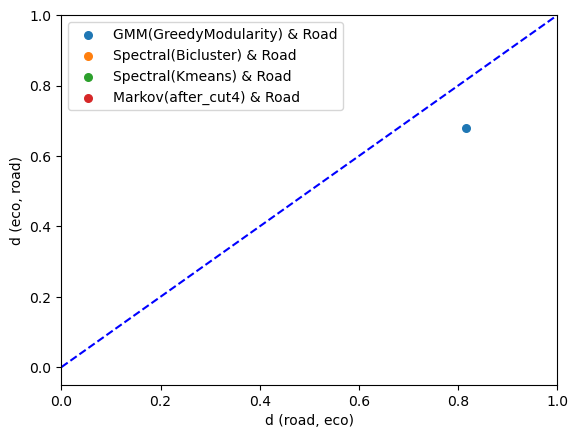

In [85]:
# plot the d_road_eco and d_eco_road column in a scatter plot, and use the color for different eco_commu_method and road_commu_method as legend
fig, ax = plt.subplots()

# set the x and y axis from 0 to 1, and add a diagonal dashed line, color is blue
ax.set_xlim(0, 1)
ax.set_ylim(-0.05, 1)
ax.plot([0, 1], [0, 1], linestyle='--', color='blue')

# set the scatter's size to 5
size = 30
# loop over the rows in the BiDir_distance dataframe
for i, row in BiDir_distance.iterrows():
    # plot the scatter plot
    ax.scatter(row['d_road_eco'], row['d_eco_road'], s=size, label=row['method_name'] + ' & Road' )


ax.set_xlabel('d (road, eco)')
ax.set_ylabel('d (eco, road)')
ax.legend()
plt.show()

In [ ]:
# plot the d_road_eco and d_eco_road column in a scatter plot, and use the color for different eco_commu_method and road_commu_method as legend
fig, ax = plt.subplots()

# set the x and y axis from 0 to 1, and add a diagonal dashed line
ax.set_xlim(0.15, 0.25)
ax.set_ylim(-0.04, 0.05)
ax.plot([0, 1], [0, 1], 'k--')
# set the scatter's size to 5
size = 30
# loop over the rows in the BiDir_distance dataframe
for i, row in BiDir_distance.iterrows():
    # plot the scatter plot
    ax.scatter(row['d_road_eco'], row['d_eco_road'], s=size, label=row['method_name'] + ' & Road')

# label each scatter point with a tuple of (d_road_eco, d_eco_road), ha is center
for i, row in BiDir_distance.iterrows():
    ax.text(row['d_road_eco'], row['d_eco_road'], (round(row['d_road_eco'], 4), round(row['d_eco_road'], 4)), ha='right')

ax.set_xlabel('d (road, eco)')
ax.set_ylabel('d (eco, road)')
ax.legend()
plt.show()

### Other approaches for comparison

In [51]:
BiDir_distance

,eco_commu_method,road_commu_method,d_road_eco,d_eco_road,F_road_road,F_road_eco,F_eco_road,F_eco_eco,method_name
0,community_GMC_id_8,community_id3,0.955003,6.969360,0.20365,0.009164,-0.012890,0.002159,GMM(GreedyModularity)
1,community_Bicluster_id_8,community_id3,1.120768,0.573554,0.20365,-0.024595,-0.012890,-0.030226,Spectral(Bicluster)
2,community_Spectral_id_8,community_id3,1.031126,0.410945,0.20365,-0.006339,-0.012890,-0.021882,Spectral(Kmeans)
3,community_8_cut4,community_id6,1.120768,3.391290,0.20365,-0.024595,0.023431,-0.009798,Markov(after_cut4)


In [52]:
eco_com_list

['community_GMC_id_8', 'community_Bicluster_id_8', 'community_Spectral_id_8']

In [53]:
# calculate the NMI between the two partitions
from sklearn.metrics import normalized_mutual_info_score

eco_com_list2 = Partition.columns[4:8].tolist()
for eco_com in eco_com_list2:
    # 将DataFrame中的划分结果转换为字典
    partition_eco = Partition.set_index('display_na')[eco_com].to_dict()
    partition_road = Partition.set_index('display_na')['community_id6'].to_dict()

    # 转换分区字典为列表
    labels_true = list(partition_road.values())
    labels_pred = list(partition_eco.values())

    # 计算NMI
    nmi_score = normalized_mutual_info_score(labels_true, labels_pred)

    # save the nmi_score to the BiDir_distance dataframe
    BiDir_distance.loc[BiDir_distance['eco_commu_method'] == eco_com, 'NMI'] = nmi_score
    # 输出结果
    print("NMI score:", nmi_score)

KeyError: 'community_id6'

In [ ]:
# add a new column called 'NMI' to the BiDir_distance DataFrame, and add the values of NMI between the two partitions
BiDir_distance

,eco_commu_method,road_commu_method,d_road_eco,d_eco_road,F_road_road,F_road_eco,F_eco_road,F_eco_eco,method_name,NMI,Jaccard
0,community_GMC_id_8,community_id6,0.352761,0.032325,1.541422,0.997668,0.969767,1.002162,GMM(GreedyModularity),0.399160,0.019608
1,community_Bicluster_id_8,community_id6,0.351484,0.000473,1.541422,0.999637,0.969767,0.970226,Spectral(Bicluster),0.445936,NaN
2,community_Spectral_id_8,community_id6,0.351309,0.008778,1.541422,0.999906,0.969767,0.978355,Spectral(Kmeans),0.421916,NaN
3,community_8_cut4,community_id6,0.378147,-0.011456,1.541422,0.958538,0.978153,0.967074,Markov(after_cut4),0.705655,NaN


In [ ]:
# calculate the Jaccard distance between the two partitions
from sklearn.metrics import jaccard_score

for eco_com in eco_com_list2:
    # 将DataFrame中的划分结果转换为字典
    partition_eco = Partition.set_index('display_na')[eco_com].to_dict()
    partition_road = Partition.set_index('display_na')['community_id6'].to_dict()

    # 转换分区字典为列表
    labels_true = list(partition_road.values())
    labels_pred = list(partition_eco.values())

    # 计算Jaccard距离
    jaccard_dist = jaccard_score(labels_true, labels_pred, average='micro')

    # save the jaccard_score to the BiDir_distance dataframe
    BiDir_distance.loc[BiDir_distance['eco_commu_method'] == eco_com, 'Jaccard'] = jaccard_dist
    # 输出结果
    print("Jaccard score:", jaccard_score)

BiDir_distance


Jaccard score: <function jaccard_score at 0x0000022E011E3740>
Jaccard score: <function jaccard_score at 0x0000022E011E3740>
Jaccard score: <function jaccard_score at 0x0000022E011E3740>
Jaccard score: <function jaccard_score at 0x0000022E011E3740>


,eco_commu_method,road_commu_method,d_road_eco,d_eco_road,F_road_road,F_road_eco,F_eco_road,F_eco_eco,method_name,NMI,Jaccard
0,community_GMC_id_8,community_id6,0.352761,0.032325,1.541422,0.997668,0.969767,1.002162,GMM(GreedyModularity),0.399160,0.019608
1,community_Bicluster_id_8,community_id6,0.351484,0.000473,1.541422,0.999637,0.969767,0.970226,Spectral(Bicluster),0.445936,0.061224
2,community_Spectral_id_8,community_id6,0.351309,0.008778,1.541422,0.999906,0.969767,0.978355,Spectral(Kmeans),0.421916,0.061224
3,community_8_cut4,community_id6,0.378147,-0.011456,1.541422,0.958538,0.978153,0.967074,Markov(after_cut4),0.705655,0.040000


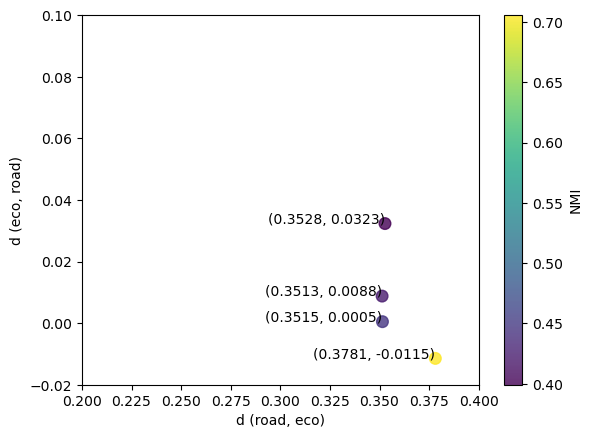

In [ ]:
# 绘制散点图
fig, ax = plt.subplots()

# 设置 x 和 y 轴范围，并添加对角线虚线
ax.set_xlim(0.2, 0.4)
ax.set_ylim(-0.02, 0.1)
ax.plot([0, 1], [0, 1], 'k--')

# 设置散点的大小
size = 70

# 根据 NMI 列的数值大小进行颜色映射
sc = ax.scatter(BiDir_distance['d_road_eco'], BiDir_distance['d_eco_road'], c=BiDir_distance['NMI'], s=size, cmap='viridis', alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('NMI')

# 为每个散点添加标签
for i, row in BiDir_distance.iterrows():
    ax.text(row['d_road_eco'], row['d_eco_road'], (round(row['d_road_eco'], 4), round(row['d_eco_road'], 4)), ha='right')

ax.set_xlabel('d (road, eco)')
ax.set_ylabel('d (eco, road)')
plt.show()

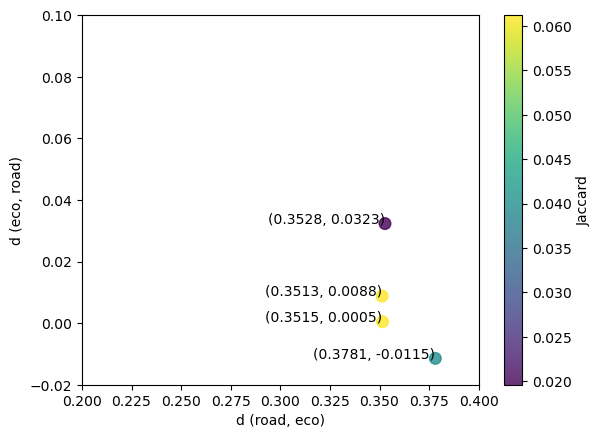

In [380]:
# 绘制散点图
fig, ax = plt.subplots()

# 设置 x 和 y 轴范围，并添加对角线虚线
ax.set_xlim(0.2, 0.4)
ax.set_ylim(-0.02, 0.1)
ax.plot([0, 1], [0, 1], 'k--')

# 设置散点的大小
size = 70

# 根据 NMI 列的数值大小进行颜色映射
sc = ax.scatter(BiDir_distance['d_road_eco'], BiDir_distance['d_eco_road'], c=BiDir_distance['Jaccard'], s=size, cmap='viridis', alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Jaccard')

# 为每个散点添加标签
for i, row in BiDir_distance.iterrows():
    ax.text(row['d_road_eco'], row['d_eco_road'], (round(row['d_road_eco'], 4), round(row['d_eco_road'], 4)), ha='right')

ax.set_xlabel('d (road, eco)')
ax.set_ylabel('d (eco, road)')
plt.show()